<a href="https://colab.research.google.com/github/drahulnayak/Breast-cancer-detection-using-CNN---Deep-Learning-/blob/main/newly_written_code_for_Breast_cancer_Detection_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-histopathology-images:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F7415%2F10564%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240815%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240815T183042Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D080da04a0587d41b77f1f3f467c269e39b81a1665972e68e0d5e58a555aa4a9b5ed7a3ddc50a5b1a9948ac50658b16f2709d7d2eb11922fa4395263e4a09a48a4377d314e70976f13dafcd0ad806e36c0b3ed12bb91d2d75ac78a7e313625e38ea3b2725211f2ec19e6e6a9b4b6aa22b6dac6c564aeb8ee226a8dd38074c89e1f6ebad6eec7b72b662d674631fef4749af2e6021bee855da3ac84c5c578b5f6e20eb3fa177fa5dcde6e9419b161ac06d4028f044c94494656f18bb1ee1969ff55fe02b25beca9838828fcded6b5874744cb8ba4ab6287aedabd6a86585c1b2612a8a26ac5ccb8e0d79362532bdd5da3a6ab38b83813b535068d9433db043d4f9,cbis-ddsm-breast-cancer-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1115384%2F1873742%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240815%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240815T183042Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D14fd239ec49b248312fe444d83487153b6cd42195d5e7eab52293283bd56eecb5f86ccd5139a2e09a0e01da6045ab622afd4ba5eec8c4de580d3a7aa9322686e26b8653a879b8f22911d8e80f4180f64c070ae7a80ba4c2f124b0a013752d4cc2e70d466bd8122005d570c6c41de28386c2099ac00fd55c5b72be2fca76010606d86c08b80380d5e24874f856a2bd3d057b39a21ce6c6b3d964ed756785d74f393d165e46e29e7371977351a44d83a9bc28d6107753688090eb2aa1f49b9dad9a223d0dfc76751cfc40c1273034d18bfd7e3af22f214f23ef1c1708925110623568dd77eab5108f38cdaf7c7bc1ecc9ce02e560430d1025ba7facdfce54e01f9'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue
print('Data source import complete.')

[==================================================] 3326820824 bytes downloaded
Downloaded and uncompressed: breast-histopathology-images
[==================================================] 5318997088 bytes downloaded
Downloaded and uncompressed: cbis-ddsm-breast-cancer-image-dataset
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import random
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import plotly.express as px

In [3]:
random.seed(100)
tf.random.set_seed(100)

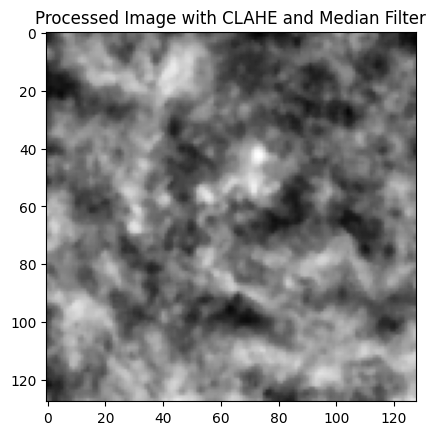

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
def load_and_preprocess_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img)
    img_median = cv2.medianBlur(img_clahe, 5)
    img_resized = cv2.resize(img_median, target_size)
    img_array = img_resized / 255.0
    img_array = np.expand_dims(img_array, axis=-1)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

image_path = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.100018879311824535125115145152454291132/1-263.jpg'
input_image = load_and_preprocess_image(image_path)
plt.imshow(input_image[0, :, :, 0], cmap='gray')
plt.title('Processed Image with CLAHE and Median Filter')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


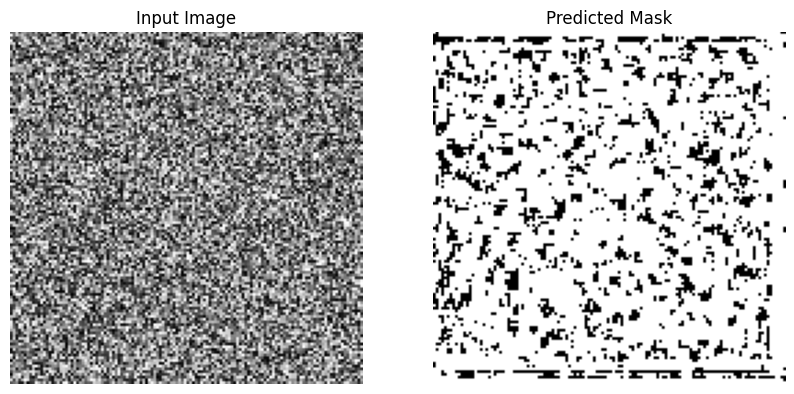

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
def segnet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    up1 = UpSampling2D(size=(2, 2))(pool2)
    up1 = Conv2D(128, 2, activation='relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)

    up2 = UpSampling2D(size=(2, 2))(conv3)
    up2 = Conv2D(64, 2, activation='relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    outputs = Conv2D(1, 1, activation='sigmoid')(conv4)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model
def display_results(input_image, predicted_mask):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image[0, :, :, 0], cmap='gray')
    plt.title('Input Image')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask[0, :, :, 0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    plt.show()
segnet = segnet_model()
input_image = np.random.rand(1, 128, 128, 1)
predicted_mask_segnet = segnet.predict(input_image)
predicted_mask_segnet = (predicted_mask_segnet > 0.5).astype(np.uint8)
display_results(input_image, predicted_mask_segnet)

In [6]:
def determine_breast_side(segmented_region):
    centroid_x = np.mean(np.nonzero(segmented_region)[1])
    centroid_y = np.mean(np.nonzero(segmented_region)[0])
    if centroid_x < segmented_region.shape[1] / 2:
        return "Left"
    else:
        return "Right"
affected_side = determine_breast_side(predicted_mask_segnet)

print("The affected side of the breast is:", affected_side)


The affected side of the breast is: Left


In [7]:
calc_case_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')

In [8]:
calc_case_df.head(5)

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [9]:
mass_case_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')

In [10]:
mass_case_df.head(5)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [11]:
dicom_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
image_dir = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

In [12]:
dicom_cleaned_data=dicom_data.copy()
dicom_cleaned_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [13]:
dicom_cleaned_data.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True)

In [14]:
dicom_cleaned_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   file_path                                    10237 non-null  object
 1   image_path                                   10237 non-null  object
 2   BitsAllocated                                10237 non-null  int64 
 3   BitsStored                                   10237 non-null  int64 
 4   BodyPartExamined                             10237 non-null  object
 5   ConversionType                               10237 non-null  object
 6   HighBit                                      10237 non-null  int64 
 7   LargestImagePixelValue                       10237 non-null  int64 
 8   Laterality                                   9671 non-null   object
 9   Modality                                     10237 non-null  object
 10  PatientID 

In [15]:
dicom_cleaned_data.isna().sum()

,0
file_path,0
image_path,0
BitsAllocated,0
BitsStored,0
BodyPartExamined,0
ConversionType,0
HighBit,0
LargestImagePixelValue,0
Laterality,566
Modality,0


In [16]:
dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)


<ipython-input-16-51dfb01b4b86>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)


In [17]:
dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)

<ipython-input-17-82d3dade18f9>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)


In [18]:
dicom_cleaned_data.isna().sum()

,0
file_path,0
image_path,0
BitsAllocated,0
BitsStored,0
BodyPartExamined,0
ConversionType,0
HighBit,0
LargestImagePixelValue,0
Laterality,0
Modality,0


In [19]:
Data_cleaning_1 = calc_case_df.copy()
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc type':'calc_type'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc distribution':'calc_distribution'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'image view':'image_view'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'breast density':'breast_density'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'abnormality type':'abnormality_type'})
Data_cleaning_1['pathology'] = Data_cleaning_1['pathology'].astype('category')
Data_cleaning_1['calc_type'] = Data_cleaning_1['calc_type'].astype('category')
Data_cleaning_1['calc_distribution'] = Data_cleaning_1['calc_distribution'].astype('category')
Data_cleaning_1['abnormality_type'] = Data_cleaning_1['abnormality_type'].astype('category')
Data_cleaning_1['image_view'] = Data_cleaning_1['image_view'].astype('category')
Data_cleaning_1['left_or_right_breast'] = Data_cleaning_1['left_or_right_breast'].astype('category')
Data_cleaning_1.isna().sum()

,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality id,0
abnormality_type,0
calc_type,20
calc_distribution,376
assessment,0
pathology,0


In [20]:
Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True)
Data_cleaning_1['calc_distribution'].fillna(method = 'bfill', axis = 0, inplace=True)
Data_cleaning_1.isna().sum()

<ipython-input-20-edf8af0774e3>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True)
<ipython-input-20-edf8af0774e3>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_1['calc_distribution'].fillna(method = 'bfill', axis = 0, inplace=True)


,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality id,0
abnormality_type,0
calc_type,0
calc_distribution,0
assessment,0
pathology,0


In [21]:
Data_cleaning_2 = mass_case_df.copy()
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass shape':'mass_shape'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass margins':'mass_margins'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'image view':'image_view'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'abnormality type':'abnormality_type'})
Data_cleaning_2['left_or_right_breast'] = Data_cleaning_2['left_or_right_breast'].astype('category')
Data_cleaning_2['image_view'] = Data_cleaning_2['image_view'].astype('category')
Data_cleaning_2['mass_margins'] = Data_cleaning_2['mass_margins'].astype('category')
Data_cleaning_2['mass_shape'] = Data_cleaning_2['mass_shape'].astype('category')
Data_cleaning_2['abnormality_type'] = Data_cleaning_2['abnormality_type'].astype('category')
Data_cleaning_2['pathology'] = Data_cleaning_2['pathology'].astype('category')
Data_cleaning_2.isna().sum()

,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality id,0
abnormality_type,0
mass_shape,4
mass_margins,43
assessment,0
pathology,0


In [22]:
Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True)
Data_cleaning_2['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True)
Data_cleaning_2.isna().sum()

<ipython-input-22-a75ac5a26e50>:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True)
<ipython-input-22-a75ac5a26e50>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_2['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True)


,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality id,0
abnormality_type,0
mass_shape,0
mass_margins,0
assessment,0
pathology,0


In [23]:
breast_imgs = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [24]:
for imgname in breast_imgs[:5]:
    print(imgname)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/13022/0/13022_idx5_x1301_y1751_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/13022/0/13022_idx5_x1901_y651_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/13022/0/13022_idx5_x1901_y701_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/13022/0/13022_idx5_x1101_y51_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/13022/0/13022_idx5_x1901_y2551_class0.png


In [25]:
non_cancer_imgs = []
cancer_imgs = []

for img in breast_imgs:
    if img[-5] == '0' :
        non_cancer_imgs.append(img)

    elif img[-5] == '1' :
        cancer_imgs.append(img)

In [26]:
non_cancer_num = len(non_cancer_imgs)  # No cancer
cancer_num = len(cancer_imgs)   # Cancer
total_img_num = non_cancer_num + cancer_num
print('Number of Images of no cancer: {}' .format(non_cancer_num))   # images of Non cancer
print('Number of Images of cancer : {}' .format(cancer_num))   # images of cancer
print('Total Number of Images : {}' .format(total_img_num))

Number of Images of no cancer: 198738
Number of Images of cancer : 78786
Total Number of Images : 277524


In [27]:
data_insight_1 = pd.DataFrame({'state of cancer' : ['0','1'],'Numbers of Patients' : [198738,78786]})

In [28]:
import plotly.express as px
bar = px.bar(data_frame=data_insight_1,
             x='state of cancer',
             y='Numbers of Patients',
             color='state of cancer')

bar.update_layout(
    title_text='Number of Patients with cancer (1) and patients with no cancer (0)',
    title_x=0.5
)
bar.show()


In [29]:
r= pd.DataFrame(dicom_cleaned_data['SeriesDescription'].value_counts())
r= r.reset_index()
r= r.rename(columns={'SeriesDescription':'SeriesDescription_counts', 'index':'SeriesDescription'})
r

,SeriesDescription_counts,count
0,cropped images,3859
1,ROI mask images,3340
2,full mammogram images,3038


In [30]:
ba_1 = px.bar(data_frame=dicom_cleaned_data, x='SeriesDescription', color='SeriesDescription',
              title='Types of images used')
ba_1.update_layout(title_text='Types of images used', title_x=0.5)
ba_1.show()

In [31]:
f= pd.DataFrame(dicom_cleaned_data['BodyPartExamined'].value_counts())
f= f.reset_index()
f= f.rename(columns={'BodyPartExamined':'BodyPartExamined_counts', 'index':'Breast part Examined'})
f


,BodyPartExamined_counts,count
0,BREAST,9671
1,Left Breast,318
2,Right Breast,248


In [32]:
ba = px.bar(data_frame=f, x="BodyPartExamined_counts", y="count", color="BodyPartExamined_counts")
ba.update_layout(title_text='Breast Parts Examined', title_x=0.5, yaxis=dict(type='log'))
ba.show()


In [33]:
data_insight_2 = pd.DataFrame({'abnormality':[Data_cleaning_1.abnormality_type[0],Data_cleaning_2.abnormality_type[0]],
                               'counts_of_abnormalties':[len(Data_cleaning_1),len(Data_cleaning_2)]})
data_insight_2

,abnormality,counts_of_abnormalties
0,calcification,1546
1,mass,1318


In [34]:

bar_2 =px.bar(data_frame=data_insight_2, x = 'abnormality', y='counts_of_abnormalties', color = 'abnormality')
bar_2.update_layout(title_text='Types of abnormalites of cancer', title_x=0.5)
bar_2.show()

In [35]:
x = Data_cleaning_1.left_or_right_breast.value_counts().RIGHT
y = Data_cleaning_1.left_or_right_breast.value_counts().LEFT
print(x,y)

728 818


In [36]:
data_insight_3 = pd.DataFrame({'left_or_right_breast':['RIGHT','LEFT'] , 'Counts':[x,y]})
data_insight_3


,left_or_right_breast,Counts
0,RIGHT,728
1,LEFT,818


In [37]:
insight_3 = px.bar(data_insight_3, y= 'Counts', x='left_or_right_breast',color = 'left_or_right_breast')
insight_3.update_layout(title_text=' clacification cancer position of the breasts ', title_x=0.5)
insight_3.show()

In [38]:
z = pd.DataFrame(Data_cleaning_1['calc_type'].value_counts())
z = z.reset_index()
z= z.rename(columns={'calc_type':'calc_type_counts'})
z

,calc_type_counts,count
0,PLEOMORPHIC,664
1,AMORPHOUS,139
2,PUNCTATE,106
3,LUCENT_CENTER,93
4,VASCULAR,82
5,FINE_LINEAR_BRANCHING,77
6,COARSE,35
7,ROUND_AND_REGULAR-LUCENT_CENTER,33
8,PLEOMORPHIC-FINE_LINEAR_BRANCHING,28
9,ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE,24


198738
78786


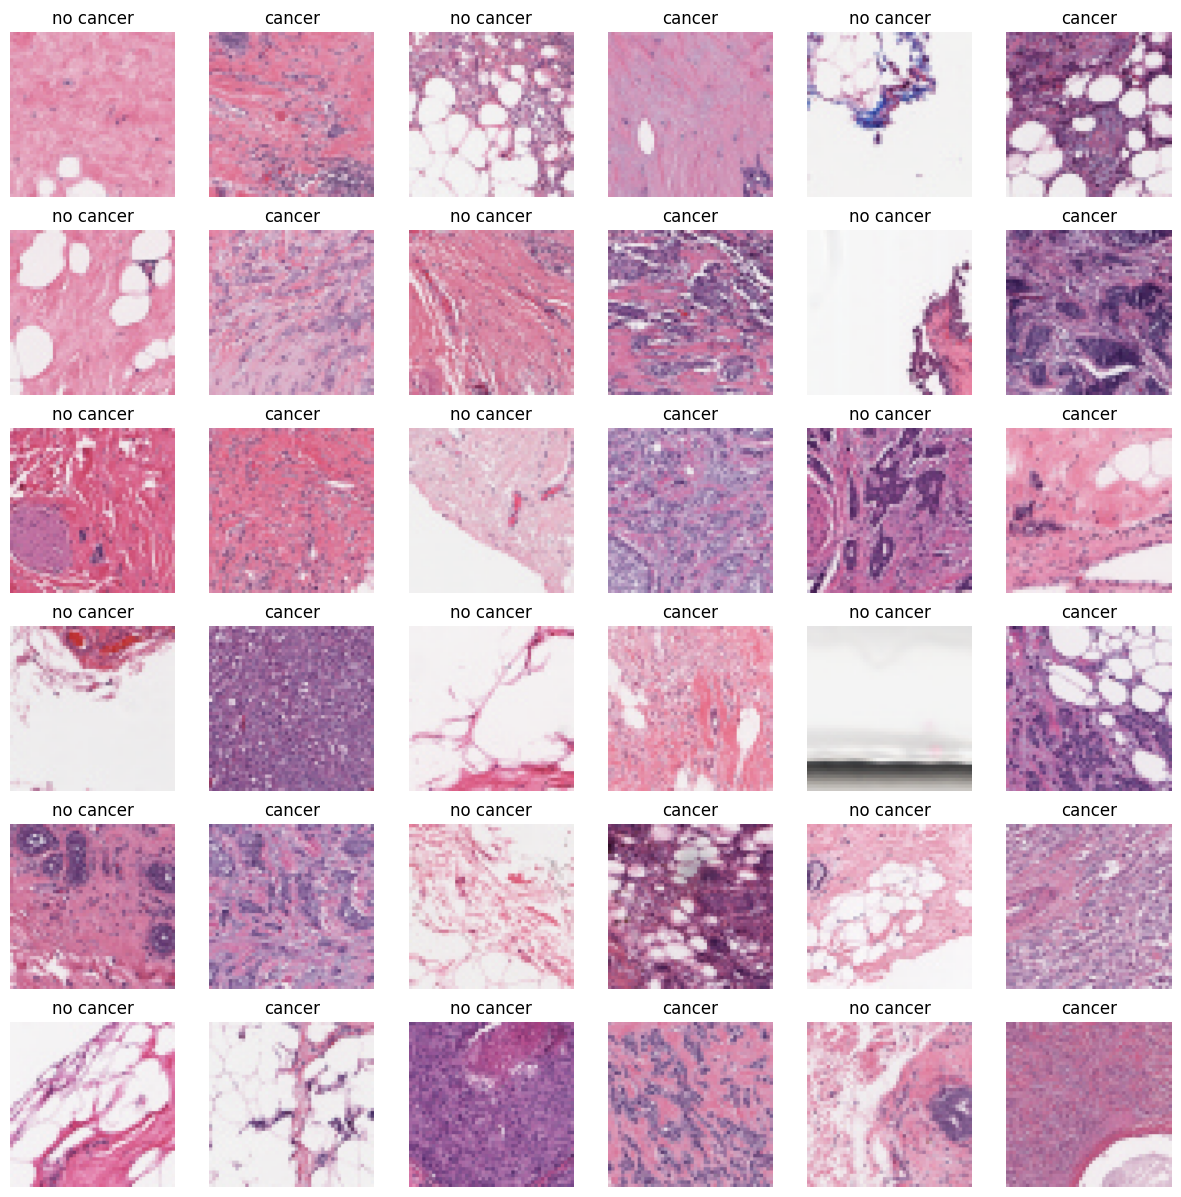

In [39]:
plt.figure(figsize = (15, 15))
print(len(non_cancer_imgs))
print(len(cancer_imgs))
some_non = np.random.randint(0, len(non_cancer_imgs), 18)
some_can = np.random.randint(0, len(cancer_imgs), 18)

s = 0
for num in some_non:

        img = image.load_img((non_cancer_imgs[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

s = 1
for num in some_can:

        img = image.load_img((cancer_imgs[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        plt.subplot(6, 6, 2*s)
        plt.axis('off')
        plt.title('cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

In [40]:
import random
import cv2
some_non_img = random.sample(non_cancer_imgs, min(len(non_cancer_imgs), 1000))  # Limiting to 1000 images
some_can_img = random.sample(cancer_imgs, min(len(cancer_imgs), 1000))
non_img_arr = []
can_img_arr = []
for img in some_non_img:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in some_can_img:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])


In [41]:
len(can_img_arr)

1000

In [42]:
X = []
y = []
non_img_arr.extend(can_img_arr)
random.shuffle(non_img_arr)

# Loop through each element (feature, label) in the shuffled 'breast_img_arr'
for feature, label in non_img_arr:
    # Append the image data (feature) to the 'X' list
    X.append(feature)
    # Append the label to the 'y' list
    y.append(label)

# Convert the lists 'X' and 'y' into NumPy arrays
X = np.array(X)
y = np.array(y)

# Print the shape of the 'X' array
print('X shape: {}'.format(X.shape))


X shape: (2000, 50, 50, 3)


In [43]:
# Split the dataset into training and testing sets, with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Define a rate (percentage) for subsampling the training data
rate = 0.5

# Calculate the number of samples to keep in the training data based on the rate
num = int(X.shape[0] * rate)

# Convert the categorical labels in 'y_train' and 'y_test' to one-hot encoded format
y_train = to_categorical(y_train, 2)  # Assuming there are 2 classes (non-cancer and cancer)
y_test = to_categorical(y_test, 2)


print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))


X_train shape : (1600, 50, 50, 3)
X_test shape : (400, 50, 50, 3)
y_train shape : (1600, 2)
y_test shape : (400, 2)


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create data generators for training and testing
train_datagen = datagen.flow(X_train, y_train, batch_size=32)
test_datagen = datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

In [45]:
# Define an EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss
    patience=5,                  # Number of epochs with no improvement after which training will be stopped
    min_delta=1e-7,              # Minimum change in the monitored quantity to be considered an improvement
    restore_best_weights=True,   # Restore model weights from the epoch with the best value of monitored quantity
)

# Define a ReduceLROnPlateau callback
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # Monitor the validation loss
    factor=0.2,           # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=2,           # Number of epochs with no improvement after which learning rate will be reduced
    min_delta=1e-7,       # Minimum change in the monitored quantity to trigger a learning rate reduction
    cooldown=0,           # Number of epochs to wait before resuming normal operation after learning rate reduction
    verbose=1             # Verbosity mode (1: update messages, 0: no messages)
)

In [46]:
# Set a random seed for reproducibility
tf.random.set_seed(42)

# Create a Sequential model
model = tf.keras.Sequential([
    # Convolutional layer with 32 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 3)),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 2x2 pool size and default stride (2)
    tf.keras.layers.MaxPooling2D(strides=2),

    # Convolutional layer with 64 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    # Convolutional layer with 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    # Convolutional layer with 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    # Flatten the output to prepare for fully connected layers
    tf.keras.layers.Flatten(),

    # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    # Output layer with 2 units (binary classification) and softmax activation
    tf.keras.layers.Dense(2, activation='softmax')
])

# Display a summary of the model architecture
model.summary()

# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 50, 50, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 50, 50, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 25, 25, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 5, 5, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 308,162 (1.18 MB)

 Trainable params: 307,458 (1.17 MB)

 Non-trainable params: 704 (2.75 KB)

In [47]:
history = model.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 25,
                    batch_size = 75,
                    callbacks=[early_stopping, plateau])

Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 865ms/step - accuracy: 0.6894 - loss: 0.8774 - val_accuracy: 0.5250 - val_loss: 6.4624 - learning_rate: 0.0010
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 829ms/step - accuracy: 0.7838 - loss: 0.5210 - val_accuracy: 0.5250 - val_loss: 5.4763 - learning_rate: 0.0010
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 816ms/step - accuracy: 0.8017 - loss: 0.4679 - val_accuracy: 0.5250 - val_loss: 4.0307 - learning_rate: 0.0010
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 834ms/step - accuracy: 0.8093 - loss: 0.4236 - val_accuracy: 0.5200 - val_loss: 3.2277 - learning_rate: 0.0010
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 21s 841ms/step - accuracy: 0.8281 - loss: 0.4110 - val_accuracy: 0.5250 - val_loss: 2.7062 - learning_rate: 0.0010
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 947ms/step - accuracy: 0.8321 - loss: 0.3813 - val_accuracy: 0.5475 - val_loss: 2.1752 - learning_rate: 0.0010
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 801ms/step - accuracy: 0.8435 - loss: 0.

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step


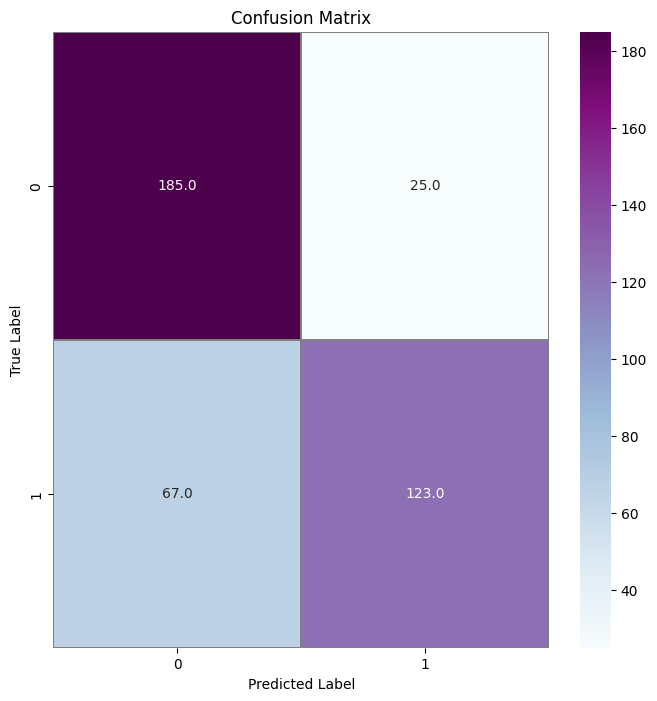

In [48]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(y_test,axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

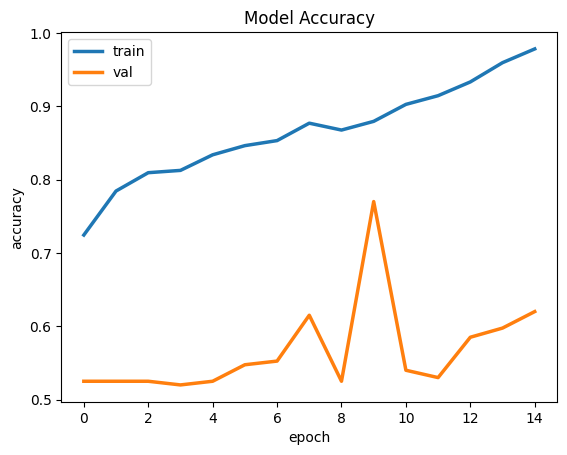

Final Training Accuracy: 97.81%
Final Validation Accuracy: 62.00%


In [49]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], linewidth=2.5)  # Set the line width for the training accuracy
plt.plot(history.history['val_accuracy'], linewidth=2.5)  # Set the line width for the validation accuracy
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Example of printing the final accuracy
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
print(f'Final Training Accuracy: {final_train_accuracy * 100:.2f}%')
print(f'Final Validation Accuracy: {final_val_accuracy * 100:.2f}%')


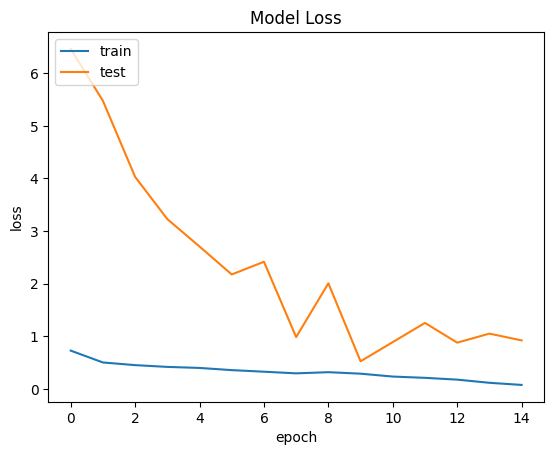

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()